In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import scipy
import scipy.stats as st
import urllib.request
import os

def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.
    
    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified 
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

## Problem 2 - Classification with DNNs

[Dr. Ali Lenjani](https://scholar.google.com/citations?user=vVPC7g0AAAAJ&hl=en) kindly provided this homework problem.
It is based on our joint work on this paper:
[Hierarchical convolutional neural networks information fusion for activity source detection in smart buildings](http://www.dpi-proceedings.com/index.php/shm2019/article/view/32353).
The data come from the [Human Activity Benchmark](http://www.ce.sc.edu/#/caicedo/custom?title=Human%20Activity%20Benchmark) published by Dr. Juan M. Caicedo.

So the problem is as follows.
You want to put sensors on a building so that it can figure out what is going on inside it.
This has applications in industrial facilities (e.g., detecting if there was an accident), public infrastructure, hospitals (e.g., did a patient fall off a bed), etc.
Typically, the problem is addressed using cameras.
Instead of cameras, we will investigate the ability of acceleration sensors to tell us what is going on.

Four acceleration sensors have been placed in different locations in the benchmark building to record the floor vibration signals of other objects falling from several heights.
A total of seven cases cases were considered:

- **bag-high:** 450 g bag containing plastic pieces is dropped roughly from 2.10 m 
- **bag-low:** 450 g bag containing plastic pieces is dropped roughly from 1.45 m
- **ball-high:** 560 g basketball is dropped roughly from 2.10 m
- **ball-low:** 560 g basketball is dropped roughly from 1.45 m
- **j-jump:** person 1.60 m tall, 55 kg jumps approximately 12 cm high
- **d-jump:** person 1.77 m tall, 80 kg jumps approximately 12 cm high
- **w-jump:** person 1.85 m tall, 85 kg jumps approximately 12 cm high

Each of these seven cases was repeated 115 times at five different building locations.
The original data are [here](http://www.ce.sc.edu/#/caicedo/custom?title=Human%20Activity%20Benchmark), but I have repackaged them for you in a more convenient format.
Let's download them:

In [5]:
# !curl -O 'https://dl.dropboxusercontent.com/s/n8dczk7t8bx0pxi/human_activity_data.npz'

Here is how to load the data:

In [6]:
data = np.load("human_activity_data.npz")

This is a Python dictionary that contains the following entries:

In [7]:
for key in data.keys():
    print(key, ":", data[key].shape)

features : (4025, 4, 3305)
labels_1 : (4025,)
labels_2 : (4025,)
loc_ids : (4025,)


Let's go over these one by one. First, the `features`.
These are the accelertion sensor measurements.
Here is how you visualize them:

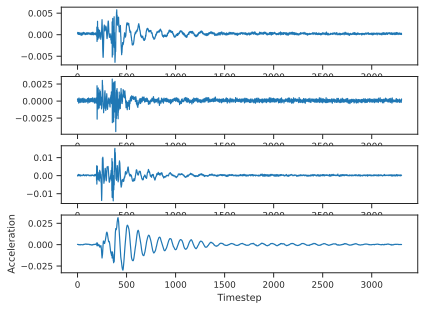

In [8]:
fig, ax = plt.subplots(4, 1, dpi=100)
# Loop over sensors
for j in range(4):
    ax[j].plot(data["features"][0, j])
ax[-1].set_xlabel("Timestep")
ax[-1].set_ylabel("Acceleration");

The second key, `labels_1`, is a bunch of integers ranging from 0 to 2 indicating whether the entry corresponds to a "bag," a "ball" or a "jump."
For your reference, the correspondence is:

In [9]:
LABELS_1_TO_TEXT = {0: "bag", 1: "ball", 2: "jump"}

And here are a few examples:

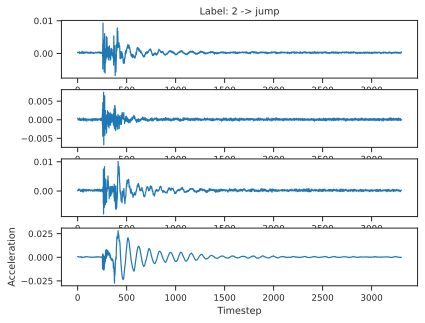

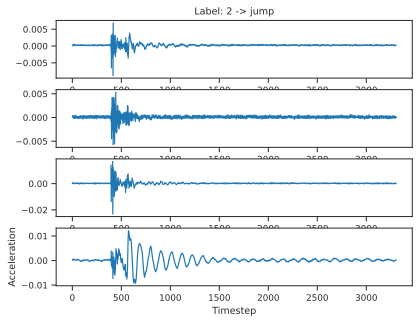

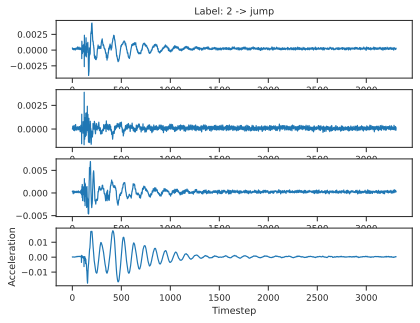

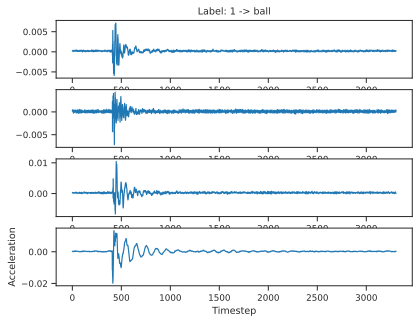

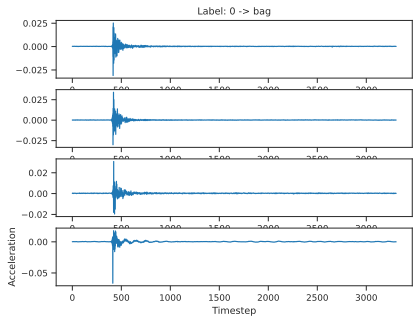

In [10]:
for _ in range(5):
    i = np.random.randint(0, data["features"].shape[0])
    fig, ax = plt.subplots(4, 1, dpi=100)
    for j in range(4):
        ax[j].plot(data["features"][i, j])
    ax[-1].set_xlabel("Timestep")
    ax[-1].set_ylabel("Acceleration")
    ax[0].set_title(
        "Label: {0:d} -> {1:s}".format(
            data["labels_1"][i], LABELS_1_TO_TEXT[data["labels_1"][i]]
        )
    )

The array `labels_2` includes integers from 0 to 6 indicating the detailed label of the experiment. The correspondence between integers and text labels is:

In [11]:
LABELS_2_TO_TEXT = {
    0: "bag-high",
    1: "bag-low",
    2: "ball-high",
    3: "ball-low",
    4: "d-jump",
    5: "j-jump",
    6: "w-jump",
}

Finally, the field `loc_ids` takes values from 0 to 4 indicating five distinct locations in the building.

Before moving forward with the questions, let's extract the data in a more covenient form:

In [12]:
# The features
X = data["features"]
# The labels_1
y1 = data["labels_1"]
# The labels_2
y2 = data["labels_2"]
# The locations
y3 = data["loc_ids"]

### Part A - Train a CNN to predict the high-level type of observation (bag, ball, or jump)

Fill in the blanks in the code blocks below to train a classification neural network that will take you from the four acceleration sensor data to the high-level type of each observation.
You can keep the network structure fixed, but you can experiment with the learning rate, the number of epochs, or anything else.
Just keep in mind that for this particular dataset, it is possible to hit an accuracy of almost 100%.

**Answer:**

The first thing that we need to do is pick a neural network structure.
Let's use 1D convolutional layers at the very beginning.
These are the same as the 2D (image) convolutional layers but in 1D.
The reason I am proposing this is that the convolutional layers are invariant to small translations of the acceleration signal (just like the labels are).
Here is what I propose:

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, num_labels=3):
        super(Net, self).__init__()
        # A convolutional layer:
        # 3 = input channels (sensors),
        # 6 = output channels (features),
        # 5 = kernel size
        self.conv1 = nn.Conv1d(4, 8, 10)
        # A 2 x 2 max pooling layer - we are going to use it two times
        self.pool = nn.MaxPool1d(5)
        # Another convolutional layer
        self.conv2 = nn.Conv1d(8, 16, 5)
        # Some linear layers
        self.fc1 = nn.Linear(16 * 131, 200)
        self.fc2 = nn.Linear(200, 50)
        self.fc3 = nn.Linear(50, num_labels)

    def forward(self, x):
        # This function implements your network output
        # Convolutional layer, followed by relu, followed by max pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Same thing
        x = self.pool(F.relu(self.conv2(x)))
        # Flatting the output of the convolutional layers
        x = x.view(-1, 16 * 131)
        # Go through the first dense linear layer followed by relu
        x = F.relu(self.fc1(x))
        # Through the second dense layer
        x = F.relu(self.fc2(x))
        # Finish up with a linear transformation
        x = self.fc3(x)
        return x

In [14]:
# You can make the network like this:
net = Net(3)

Now, you need to pick the right loss function for classification tasks:

In [15]:
cnn_loss_func = nn.CrossEntropyLoss()

Just like before, let's organize our training code in a convenient function that allows us to play with the parameters of training.
Fill in the missing code.

In [16]:
from sklearn.model_selection import train_test_split
def train_cnn(X, y, net, n_batch, epochs, lr, test_size=0.33):
    """
    A function that trains a regression neural network using stochastic gradient
    descent and returns the trained network. The loss function being minimized is
    `loss_func`.
    
    Parameters:
    
    X          -    The observed features
    y          -    The observed targets
    net        -    The network you want to fit
    n_batch    -    The batch size you want to use for stochastic optimization
    epochs     -    How many times do you want to pass over the training dataset.
    lr         -    The learning rate for the stochastic optimization algorithm.
    test_size  -    What percentage of the data should be used for testing (validation).
    """
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
        
    # Turn all the numpy arrays to torch tensors
    X_train = torch.Tensor(X_train)
    X_test = torch.Tensor(X_test)
    y_train = torch.LongTensor(y_train)
    y_test = torch.LongTensor(y_test)
    
    # This is pytorch magick to enable shuffling of the
    # training data every time we go through them
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_data_loader = torch.utils.data.DataLoader(train_dataset, 
                                                    batch_size=n_batch,
                                                    shuffle=True)
    
    # Create an Adam optimizing object for the neural network `net`
    # with learning rate `lr`
    optimizer = torch.optim.Adam(params=net.parameters(), lr=lr)
    
    # This is a place to keep track of the test loss
    test_loss = []
    # This is a place to keep track of the accuracy on each epoch
    accuracy = []
    
    # Iterate the optimizer. 
    # Remember, each time we go through the entire dataset we complete an `epoch`
    # I have wrapped the range around tqdm to give you a nice progress bar
    # to look at
    for e in range(epochs):
        # This loop goes over all the shuffled training data
        # That's why the DataLoader class of PyTorch is convenient
        for X_batch, y_batch in train_data_loader:
            # Perform a single optimization step with loss function
            # cnn_loss_func(y_batch, y_pred, reg_weight)
            # Hint 1: You have defined cnn_loss_func() already
            # Hint 2: Consult the hands-on activities for an example
            # your code here

            optimizer.zero_grad()
            
            y_pred = net(X_batch)
            
            loss = cnn_loss_func(y_pred, y_batch) # + reg_weight * l2_reg_loss(params)

            loss.backward()
            
            optimizer.step()

        # Evaluate the test loss and append it on the list `test_loss`
        y_pred_test = net(X_test)
        ts_loss = cnn_loss_func(y_pred_test, y_test)
        test_loss.append(ts_loss.item())
        # Evaluate the accuracy
        _, predicted = torch.max(y_pred_test.data, 1)
        correct = (predicted == y_test).sum().item()
        accuracy.append(correct / y_test.shape[0])
        # Print something about the accuracy
        print(f'Epoch {e+1}: accuracy = {accuracy[-1]:1.5f}, test loss = {ts_loss.item()}')
    trained_model = net
    
    # Return everything we need to analyze the results
    return trained_model, test_loss, accuracy, X_train, y_train, X_test, y_test

Now experiment with the epochs, the learning rate, and the batch size until this works.

In [17]:
epochs = 20
lr = 0.001
n_batch = 30
trained_model, test_loss, accuracy, X_train, y_train, X_test, y_test = train_cnn(
    X, y1, net, n_batch, epochs, lr
)

Epoch 1: accuracy = 0.42814, test loss = 1.0789012908935547
Epoch 2: accuracy = 0.58916, test loss = 0.8401238322257996
Epoch 3: accuracy = 0.86832, test loss = 0.3546644449234009
Epoch 4: accuracy = 0.94959, test loss = 0.1626487821340561
Epoch 5: accuracy = 0.96012, test loss = 0.09905602782964706
Epoch 6: accuracy = 0.96689, test loss = 0.09010393917560577
Epoch 7: accuracy = 0.98947, test loss = 0.041446004062891006
Epoch 8: accuracy = 0.98119, test loss = 0.049356844276189804
Epoch 9: accuracy = 0.99398, test loss = 0.028473541140556335
Epoch 10: accuracy = 0.98947, test loss = 0.03181810304522514
Epoch 11: accuracy = 0.99022, test loss = 0.029633384197950363
Epoch 12: accuracy = 0.98947, test loss = 0.032728832215070724
Epoch 13: accuracy = 0.99473, test loss = 0.021325957030057907
Epoch 14: accuracy = 0.99398, test loss = 0.022522645071148872
Epoch 15: accuracy = 0.99549, test loss = 0.016805704683065414
Epoch 16: accuracy = 0.99549, test loss = 0.01831093057990074
Epoch 17: acc

Plot the evolution of the test loss as a function of epochs.

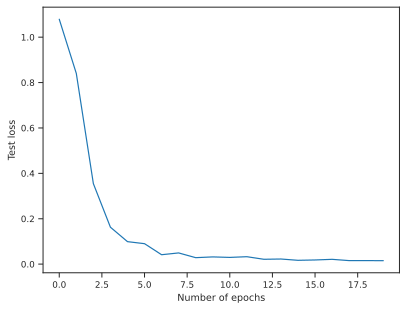

In [18]:
fig, ax = plt.subplots(dpi=100)
ax.plot(test_loss)
ax.set_xlabel("Number of epochs")
ax.set_ylabel("Test loss");

Plot the evolution of the accuracy as a function of epochs.

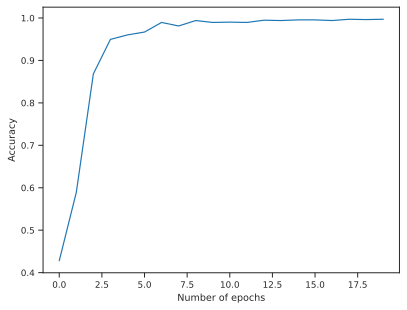

In [19]:
fig, ax = plt.subplots(dpi=100)
ax.plot(accuracy)
ax.set_xlabel("Number of epochs")
ax.set_ylabel("Accuracy");

Plot the confusion matrix.

In [20]:
from sklearn.metrics import confusion_matrix

# Predict on the test data
y_pred_test = trained_model(X_test)
# Remember that the prediction is probabilisticEpoch
# We need to simply pick the label with the highest probability:
_, y_pred_labels = torch.max(y_pred_test, 1)
# Here is the confusion matrix:
cf_matrix = confusion_matrix(y_test, y_pred_labels)

<Axes: >

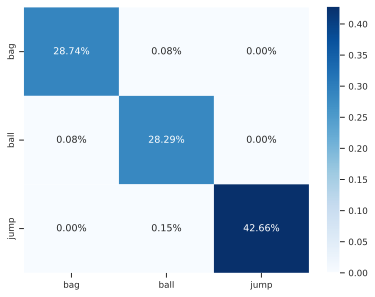

In [21]:
sns.heatmap(
    cf_matrix / np.sum(cf_matrix),
    annot=True,
    fmt=".2%",
    cmap="Blues",
    xticklabels=LABELS_1_TO_TEXT.values(),
    yticklabels=LABELS_1_TO_TEXT.values(),
);

### Part B - Train a CNN to predict the the low-level type of observation (bag-high, bag-low, etc.)

Repeat what you did above for `y2`.

**Answer:**

In [62]:
net = Net(7)

In [63]:
# 93%
epochs = 75
lr = 0.0011#5
n_batch = 30
trained_model, test_loss, accuracy1, X_train, y_train, X_test, y_test = train_cnn(
    X, y2, net, n_batch, epochs, lr
)

# epochs = 50
# lr = 0.001
# n_batch = 30
# trained_model, test_loss, accuracy, X_train, y_train, X_test, y_test = train_cnn(
#     X, y2, trained_model, n_batch, epochs, lr
# )

# epochs = 50
# lr = 0.0008
# n_batch = 30
# trained_model, test_loss, accuracy, X_train, y_train, X_test, y_test = train_cnn(
#     X, y2, trained_model, n_batch, epochs, lr
# )

Epoch 1: accuracy = 0.13544, test loss = 1.9481254816055298
Epoch 2: accuracy = 0.21971, test loss = 1.9472490549087524
Epoch 3: accuracy = 0.32581, test loss = 1.6053467988967896
Epoch 4: accuracy = 0.48382, test loss = 0.9431935548782349
Epoch 5: accuracy = 0.56885, test loss = 0.8121996521949768
Epoch 6: accuracy = 0.61926, test loss = 0.6951909065246582
Epoch 7: accuracy = 0.67720, test loss = 0.6179391741752625
Epoch 8: accuracy = 0.72009, test loss = 0.5512562394142151
Epoch 9: accuracy = 0.72837, test loss = 0.5080915689468384
Epoch 10: accuracy = 0.74944, test loss = 0.4774286150932312
Epoch 11: accuracy = 0.78179, test loss = 0.4588487148284912
Epoch 12: accuracy = 0.79684, test loss = 0.42733168601989746
Epoch 13: accuracy = 0.81490, test loss = 0.4014044404029846
Epoch 14: accuracy = 0.78932, test loss = 0.3919968903064728
Epoch 15: accuracy = 0.85854, test loss = 0.34297049045562744
Epoch 16: accuracy = 0.85929, test loss = 0.30646389722824097
Epoch 17: accuracy = 0.86080, 

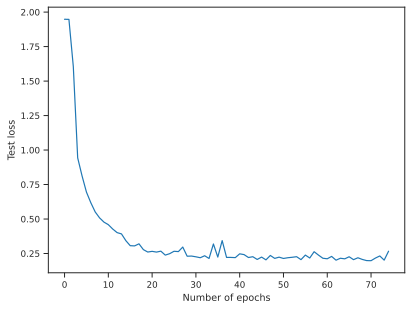

In [64]:
fig, ax = plt.subplots(dpi=100)
ax.plot(test_loss)
ax.set_xlabel("Number of epochs")
ax.set_ylabel("Test loss");

Plot the evolution of the accuracy as a function of epochs.

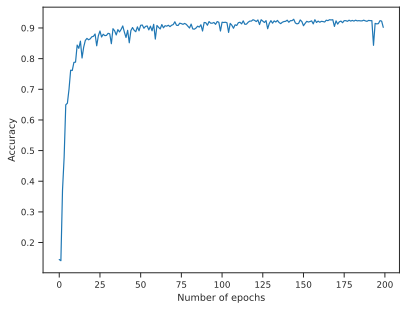

In [65]:
fig, ax = plt.subplots(dpi=100)
ax.plot(accuracy)
ax.set_xlabel("Number of epochs")
ax.set_ylabel("Accuracy");

Plot the confusion matrix.

In [66]:
from sklearn.metrics import confusion_matrix

# Predict on the test data
y_pred_test = trained_model(X_test)
# Remember that the prediction is probabilisticEpoch
# We need to simply pick the label with the highest probability:
_, y_pred_labels = torch.max(y_pred_test, 1)
# Here is the confusion matrix:
cf_matrix = confusion_matrix(y_test, y_pred_labels)

<Axes: >

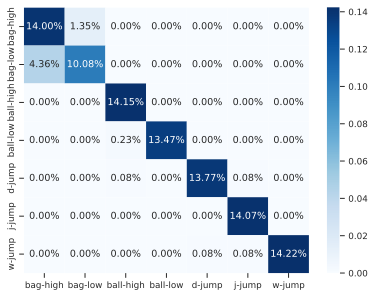

In [28]:
sns.heatmap(
    cf_matrix / np.sum(cf_matrix),
    annot=True,
    fmt=".2%",
    cmap="Blues",
    xticklabels=LABELS_2_TO_TEXT.values(),
    yticklabels=LABELS_2_TO_TEXT.values(),
);